In [1]:
#SEP test

In [49]:
%matplotlib inline
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy import wcs

# Functions

In [3]:
# returns the indices of a list in descending order
def sort_reverse_index(x):
        return sorted(range(len(x)), key=lambda k: x.max()-x[k])

In [4]:
#imports fits and puts into numpy array
def load_fits(filename):
    hdu_list = fits.open(filename, do_not_scale_image_data=True)
    tbdat = hdu_list[0].data
    tbdat = tbdat.byteswap().newbyteorder()
    return tbdat

In [33]:
#cuts the exposure images to 2000X2000, as the mosaic is just 2000X2000
def cut_exp(tbdat):
    tbdat = np.delete(tbdat, list(range(2000, 2036)),0)
    tbdat = np.delete(tbdat, list(range(2000, 2036)),1)
    return tbdat

The zero function finds the "zero point". The zero point it the magnitude of an object that produces one count per second. This value 'ABMAG' pulled from the fits header information.

In [5]:
#function gives zero point from exposure 1. All exposures should have the same zero point.
def zero(filename):
    hdu_list = fits.open(filename, do_not_scale_image_data=True)
    zero_point = hdu_list[0].header['ABMAG']
    return zero_point

In [6]:
#subtracts background from image
def subtraction(tbdat, bkg):
    bkg_rms = bkg.rms()	#background noise as 2d array
    tbdat_sub = tbdat - bkg #subtract background
    return tbdat_sub

The extraction function below performs the actual extraction on the image from which the background has been subtracted. There are several options that can be input here. They are:
    * Thresh - The detection threshold. A detected object is distinguished at this threshold (e.g 5.0*err).
    * err - In the below example is the global rms. 

In [7]:
#perform the extraction
def extraction(tbdat_sub, bkg):
    objects = sep.extract(tbdat_sub, thresh = 5.0, err = bkg.globalrms)
    return objects

The kron_info function below returns the Kron radius within an ellipse and any flags associated. The Kron radius is defined by Barbary (2016) as:
$$\sum_{i} r_{i}I(r_{i})/\sum_{i}I(r_{i})$$,
where $r_{i}$ is the distance to the pixel from the ellipse. The Kron aperature photometry is a proposed technique that captures the majority of the flux. $r$ in the function is the ellipse radius which is integrated over. 


In [8]:
#Gets kron radius information
def kron_info(objects, tbdat_sub):
    kronrad, kronflag = sep.kron_radius(tbdat_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], r=6.0)
    return kronrad, kronflag


The find_flux function below finds the flux, flux errors, and extraction flags from the background subtracted image. An elliptical apeture is used unless the $kr\sqrt{a * b}$ is smaller than a given radius, where kr, a, and b are the kron radius, semi-major, and semi-minor axes respectively. Then a circular appature is used. 

The sum_ellipse and sum_circle functions utalize the following inputs:
    * r - Scaling factor for a and b
    * subpix - subpixel sampling?
The flux error is calculated by
$$ \sigma^{2}_{F} = \sum_{i}\sigma^{2}_{i} + F/g$$
where $\sigma_i$ is the pixel noise, F is the sum in the aperature, and g is the gain.

The process of finding the Kron radius, performing elliptical aperature phtometry, and then circular aperture photomety (if kr is too small) is equivilent to FLUX_AUTO in SExtractor.
    
The flux_radius function returns the radius of a circle enclosing fraction of total flux (analogous to Kron radius for ellipse?). Inputs include:
    * frac - Requested fraction of light (0-1). E.g. frac=0.5 would give the radius of a circle contining half the      total flux of the object.
    * rmax - Max radius to analyze
    * normflux - a normalizing flux, rmax is used if not given
    
The winpos function returns paramteres used to get more accurate object centroid. From documentation: "On each iteration, the centroid is calculated using all pixels within a circular aperture of 4*sig from the current position, weighting pixel positions by their flux and the amplitude of a 2-d Gaussian with sigma sig. Iteration stops when the change in position falls under some threshold or a maximum number of iterations is reached." Sigma for the Gaussian is 2.0 / (2.35 * half light radius). 

In [9]:
#Finds flux, flux error, and extraction flags
def find_flux(tbdat_sub, bkg, objects, kronrad, kronflag):
    flux, fluxerr, flag = sep.sum_ellipse(tbdat_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], r = (2.5*kronrad), err = bkg.globalrms, subpix=1)
    flag |=kronflag #combines all flags
    r_min = 1.75 #minimum diameter = 3.5
    use_circle = kronrad * np.sqrt(objects['a'] * objects['b']) < r_min
    cflux, cfluxerr, cflag = sep.sum_circle(tbdat_sub, objects['x'][use_circle], objects['y'][use_circle], r_min, subpix=1)
    flux[use_circle] = cflux
    fluxerr[use_circle] = cfluxerr
    flag[use_circle] = cflag
    r, rflag = sep.flux_radius(tbdat_sub, objects['x'], objects['y'], rmax = 6.0*objects['a'], frac = 0.5, normflux = flux, subpix =5)
    sig = 2.0 / (2.35*r) # r from sep.flux_radius() above, with fluxfrac = 0.5
    xwin, ywin, wflag = sep.winpos(tbdat_sub, objects['x'], objects['y'], sig)
    return flux, fluxerr, flag, r, xwin, ywin


In [75]:
#convert extraction flux to AB magnitude
def magnitude(flux, zero_point):
    mag = -2.5*np.log10(flux) + zero_point
    return mag

In [11]:
#reads in catalog used to generated exposures and puts info into arrays
def read_cat(filename):
    f = open(filename, "r")
    line = f.readlines()
    f.close()
    num_cat = np.array([])
    ra_cat = np.array([])
    dec_cat = np.array([])
    mag_cat = np.array([])
    z_cat = np.array([])
    s_cat = np.array([])
    for i in range(len(line)):
        num_cat = np.append(num_cat, int(line[i].split()[0]))
        ra_cat = np.append(ra_cat, float(line[i].split()[1]))
        dec_cat = np.append(dec_cat, float(line[i].split()[2]))
        mag_cat = np.append(mag_cat, float(line[i].split()[3]))
        z_cat = np.append(z_cat, float(line[i].split()[4]))
        s_cat = np.append(s_cat, float(line[i].split()[9]))
    return num_cat, ra_cat, dec_cat, mag_cat, z_cat, s_cat

In [32]:
#convert pixel location of objectes extracted from image to ra and dec
def world(filename, objects):
    hdu_list = fits.open(filename)
    w = wcs.WCS(hdu_list[0].header)
    hdu_list.close()
    wrd = w.wcs_pix2world(objects['x'], objects['y'], np.zeros(len(objects['x'])), 0) #double check this!!!!!
    ra = wrd[:][0]
    dec = wrd[:][1]
    return ra, dec

In [45]:
#convert pixel location of corners of image to ra and dec
def world_area(filename, tbdat):
    hdu_list = fits.open(filename)
    w = wcs.WCS(hdu_list[0].header)
    hdu_list.close()
    world_min = w.wcs_pix2world(0,0,0,0)
    world_max = w.wcs_pix2world(len(tbdat), len(tbdat), 0, 0)
    return world_min, world_max

# Exposure 1 extraction

In [76]:
fname_exp1 = 'simple_sim_cube_F090W_487_01.slp.fits'
tbdat_exp1 = load_fits(fname_exp1)
tbdat_exp1 = cut_exp(tbdat_exp1)
tbdat_exp1 = np.ascontiguousarray(tbdat_exp1) #Converts cut array to C-order memory
zero_point = zero(fname_exp1)
bkg_exp1 = sep.Background(tbdat_exp1) #measures background
tbdat_sub_exp1 = subtraction(tbdat_exp1, bkg_exp1)
objects_exp1 = extraction(tbdat_sub_exp1, bkg_exp1) #extraction
print('number of exposure 1 sources', len(objects_exp1['x']))
kronrad_exp1, kronflag_exp1 = kron_info(objects_exp1, tbdat_sub_exp1)
flux_exp1, fluxerr_exp1, flag_exp1, r_exp1, xwin_exp1, ywin_exp1= find_flux(tbdat_sub_exp1, bkg_exp1, objects_exp1, kronrad_exp1, kronflag_exp1) #photometry
mag_exp1 = magnitude(flux_exp1, zero_point) #Converts flux to AB Magnitude

('number of exposure 1 sources', 65)


# Exposure 2 Extraction

In [77]:
fname_exp2 = 'simple_sim_cube_F090W_487_02.slp.fits'
tbdat_exp2 = load_fits(fname_exp2)
tbdat_exp2 = cut_exp(tbdat_exp2)
tbdat_exp2 = np.ascontiguousarray(tbdat_exp2)#Converts cut array to C-order memory
bkg_exp2 = sep.Background(tbdat_exp2) #measures background
tbdat_sub_exp2 = subtraction(tbdat_exp2, bkg_exp2)
objects_exp2 = extraction(tbdat_sub_exp2, bkg_exp2) #extraction
print('number of exposure 2 sources', len(objects_exp2['x']))
kronrad_exp2, kronflag_exp2 = kron_info(objects_exp2, tbdat_sub_exp2)
flux_exp2, fluxerr_exp2, flag_exp2, r_exp2, xwin_exp2, ywin_exp2= find_flux(tbdat_sub_exp2, bkg_exp2, objects_exp2, kronrad_exp2, kronflag_exp2,) #photometry
mag_exp2 = magnitude(flux_exp2, zero_point) #Converts flux to AB Magnitude

('number of exposure 2 sources', 64)


# Exposure 3 Extraction

In [78]:
fname_exp3 = 'simple_sim_cube_F090W_487_03.slp.fits'
tbdat_exp3 = load_fits(fname_exp3)
tbdat_exp3 = cut_exp(tbdat_exp3)
tbdat_exp3 = np.ascontiguousarray(tbdat_exp3)#Converts cut array to C-order memory
bkg_exp3 = sep.Background(tbdat_exp3) #measures background
tbdat_sub_exp3 = subtraction(tbdat_exp3, bkg_exp3)
objects_exp3 = extraction(tbdat_sub_exp3, bkg_exp3) #extraction
print('number of exposure 3 sources', len(objects_exp3['x']))
kronrad_exp3, kronflag_exp3 = kron_info(objects_exp3, tbdat_sub_exp3)
flux_exp3, fluxerr_exp3, flag_exp3, r_exp3, xwin_exp3, ywin_exp3= find_flux(tbdat_sub_exp3, bkg_exp3, objects_exp3, kronrad_exp3, kronflag_exp3) #photometry
mag_exp3 = magnitude(flux_exp3, zero_point) #Converts flux to AB Magnitude

('number of exposure 3 sources', 62)


# Exposure 4 Extraction

In [79]:
fname_exp4 = 'simple_sim_cube_F090W_487_04.slp.fits'
tbdat_exp4 = load_fits(fname_exp4)
tbdat_exp4 = cut_exp(tbdat_exp4)
tbdat_exp4 = np.ascontiguousarray(tbdat_exp4)#Converts cut array to C-order memory
bkg_exp4 = sep.Background(tbdat_exp4) #measures background
tbdat_sub_exp4 = subtraction(tbdat_exp4, bkg_exp4)
objects_exp4 = extraction(tbdat_sub_exp4, bkg_exp4) #extraction
print('number of exposure 4 sources', len(objects_exp4['x']))
kronrad_exp4, kronflag_exp4 = kron_info(objects_exp4, tbdat_sub_exp4)
flux_exp4, fluxerr_exp4, flag_exp4, r_exp4, xwin_exp4, ywin_exp4= find_flux(tbdat_sub_exp4, bkg_exp4, objects_exp4, kronrad_exp4, kronflag_exp4) #photometry
mag_exp4 = magnitude(flux_exp4, zero_point) #Converts flux to AB Magnitude

('number of exposure 4 sources', 65)


# Mosic Image Extraction

In [80]:
fname_img =  'H.fits'
tbdat = load_fits(fname_img)
bkg = sep.Background(tbdat) #measures background
tbdat_sub = subtraction(tbdat, bkg)
objects = extraction(tbdat_sub, bkg) #extraction of mosaic image
print('number of mosaic sources', len(objects['x']))
kronrad, kronflag = kron_info(objects, tbdat_sub) #Finds Kron Radius
flux, fluxerr, flag, r, xwin, ywin= find_flux(tbdat_sub, bkg, objects, kronrad, kronflag) #Finds flux from aperature phot.
mag = magnitude(flux, zero_point)

('number of mosaic sources', 67)


# Catalog Information

In [81]:
num_cat, ra_cat, dec_cat, mag_cat, z, s = read_cat('candels_with_fake_mag.cat')

# Get WCS Info of All Objects Extracted from Exposures 

In [82]:
ra_exp1, dec_exp1 = world(fname_exp1, objects_exp1)
ra_exp2, dec_exp2 = world(fname_exp2, objects_exp2)
ra_exp3, dec_exp3 = world(fname_exp3, objects_exp3)
ra_exp4, dec_exp4 = world(fname_exp4, objects_exp4)

# Get RA & DEC of Exposure Area

In [83]:
world_min_exp1, world_max_exp1 = world_area(fname_exp1, tbdat_exp1)
world_min_exp2, world_max_exp2 = world_area(fname_exp2, tbdat_exp2)
world_min_exp3, world_max_exp3 = world_area(fname_exp3, tbdat_exp3)
world_min_exp4, world_max_exp4 = world_area(fname_exp4, tbdat_exp4)

print(world_min_exp1, world_max_exp1)

([array(53.10134917350744), array(-27.813741693747467), array(1.0)], [array(53.12117721673453), array(-27.79658422069182), array(1.0)])


# Plot exposure 1 image and catlog over

Extent in imshow is "The location, in data-coordinates, of the lower-left and upper-right corners." Done as extent=[horizontal_min,horizontal_max,vertical_min,vertical_max]. 

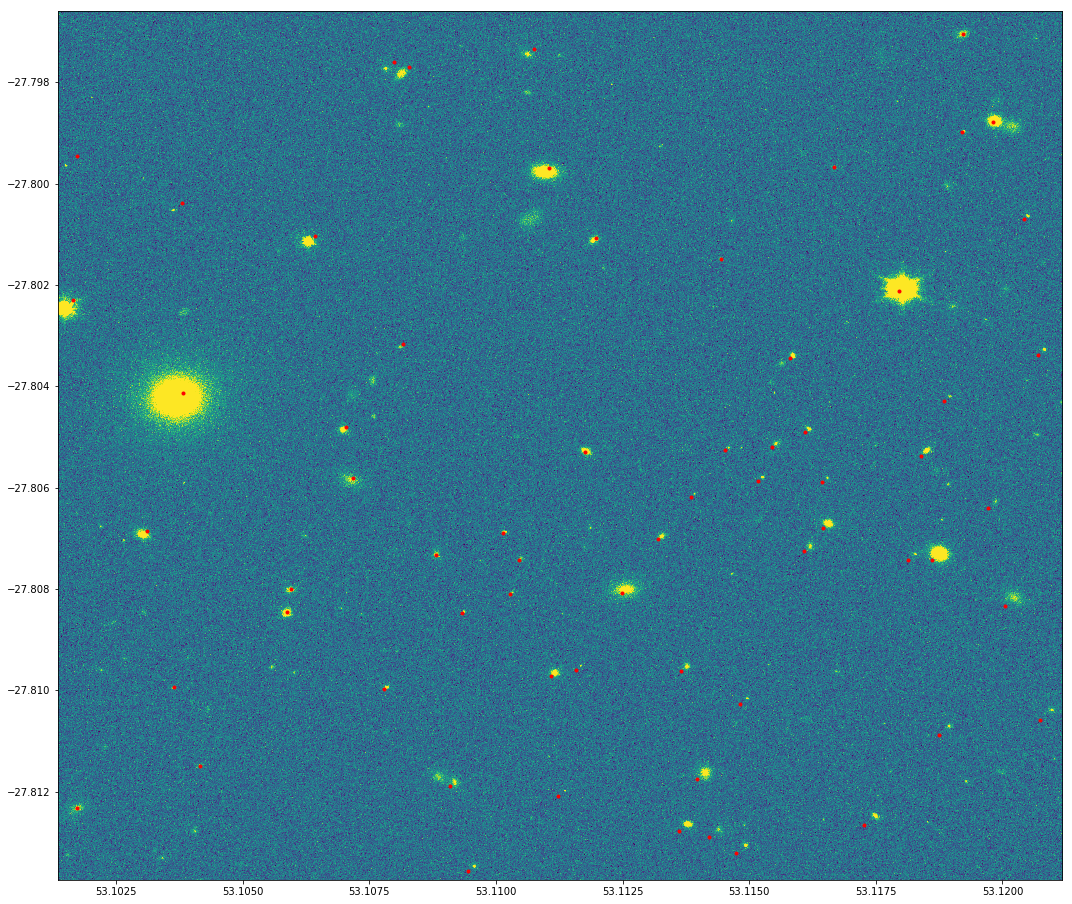

In [62]:
fig=plt.figure(figsize=(18, 16))
plt.imshow(tbdat_exp1, vmin=0.093537331, vmax=0.21167476, interpolation='none', origin='lower', extent = [world_min_exp1[0], world_max_exp1[0], world_min_exp1[1], world_max_exp1[1]])
plt.plot(ra_exp1, dec_exp1, '.', color = 'red')
#plt.plot(ra_cat, dec_cat, '.', color ='white')   

# List Brightest 100 Catalog Sources

In [100]:
#prints souces in magnitude decreasing order with corresponding ra/dec (highest 100 flux)
index = sort_reverse_index(mag_cat)
print"number", "\t", "\t", "ABMag", "\t", "RA", "\t", "\t", "DEC"
for j in range(7500,8000):
    k = index[j]
    print num_cat[k], "\t", mag_cat[k], ra_cat[k], "\t", dec_cat[k]


number 		ABMag 	RA 		DEC
28403.0 	26.768 53.086864 	-27.864943
33687.0 	26.768 53.118549 	-27.718735
4528.0 	26.767 53.164875 	-27.869091
7478.0 	26.767 53.118755 	-27.839947
13024.0 	26.767 53.074688 	-27.793301
28179.0 	26.767 53.130859 	-27.871689
29943.0 	26.767 53.214912 	-27.820532
33595.0 	26.767 53.092907 	-27.721706
14590.0 	26.766 53.084679 	-27.783243
20035.0 	26.766 53.047367 	-27.739864
20580.0 	26.766 53.08786 	-27.73477
25606.0 	26.766 53.131973 	-27.69525
26314.0 	26.766 53.117813 	-27.702309
27094.0 	26.766 53.166416 	-27.921688
27114.0 	26.766 53.204742 	-27.919241
27258.0 	26.766 53.156849 	-27.909452
28430.0 	26.766 53.159695 	-27.864206
33736.0 	26.766 53.063568 	-27.717201
34267.0 	26.766 53.187233 	-27.688379
34547.0 	26.766 53.185757 	-27.695871
8319.0 	26.765 53.128731 	-27.832779
11844.0 	26.765 53.142006 	-27.802099
19210.0 	26.765 53.164883 	-27.747614
26946.0 	26.765 53.115906 	-27.935432
28879.0 	26.765 53.060825 	-27.850302
33083.0 	26.765 53.149857 	-27.

# List Brightest 50 Sources From Exposure 1

In [86]:
#prints souces in magnitude decreasing order with corresponding ra/dec (highest 50 flux)
index = sort_reverse_index(mag_exp1)
print"number", "\t", "\t", "ABMag", "\t", "RA", "\t", "\t", "DEC"
for j in range(50):
    k = index[j]
    print k, "\t", mag_exp1[k], ra_exp1[k], "\t", dec_exp1[k]

number 		ABMag 	RA 		DEC
6 	26.7674511186 53.1112281261 	-27.8120790861
34 	26.5119060998 53.1138467929 	-27.8061773708
13 	26.4323676131 53.1036412774 	-27.8099313496
58 	26.2522377662 53.1017235947 	-27.799453985
51 	26.1958997155 53.1144430568 	-27.801490441
40 	26.1602940855 53.1145282351 	-27.8052562733
16 	26.1446597853 53.11157836 	-27.8095905044
36 	26.0357168874 53.1164461489 	-27.8058933125
21 	25.952882628 53.1102729867 	-27.8081029192
56 	25.9427315125 53.1166779813 	-27.7996796868
44 	25.9416909073 53.118855043 	-27.8042892225
12 	25.8877508113 53.114811977 	-27.8102808108
55 	25.8594101159 53.1038044172 	-27.8003739274
33 	25.7458981018 53.1197063198 	-27.8064083483
59 	25.7106179114 53.1192090981 	-27.7989882767
25 	25.700536851 53.118133662 	-27.8074362089
48 	25.6548709353 53.108171216 	-27.8031691
9 	25.6319740318 53.1041522717 	-27.8114927567
18 	25.3978019482 53.1093243558 	-27.8084762569
24 	25.3213929304 53.1104494703 	-27.8074343469
54 	25.3159019948 53.120422730

# Just Tests below

In [121]:
hdu_list = fits.open(fname_img)
w = wcs.WCS(hdu_list[0].header)
hdu_list.close()
world_min = w.wcs_pix2world(0,0,0)
world_max = w.wcs_pix2world(len(tbdat), len(tbdat), 0) 

print(world_min, world_max)
print
print(world_min_exp1, world_max_exp1)
#world min and max for exposure1 and mosaic are the same, as I expected. 
#The catalog ra and decs are larger than what I have, maybe in cut-off region? 

([array(53.10134917350744), array(-27.813741693747467)], [array(53.12117721673453), array(-27.79658422069182)])

([array(53.10134917350744), array(-27.813741693747467), array(1.0)], [array(53.12117721673453), array(-27.79658422069182), array(1.0)])


(53.145102999999999, -27.837368000000001, 53.111228126086615, -27.812079086095302)


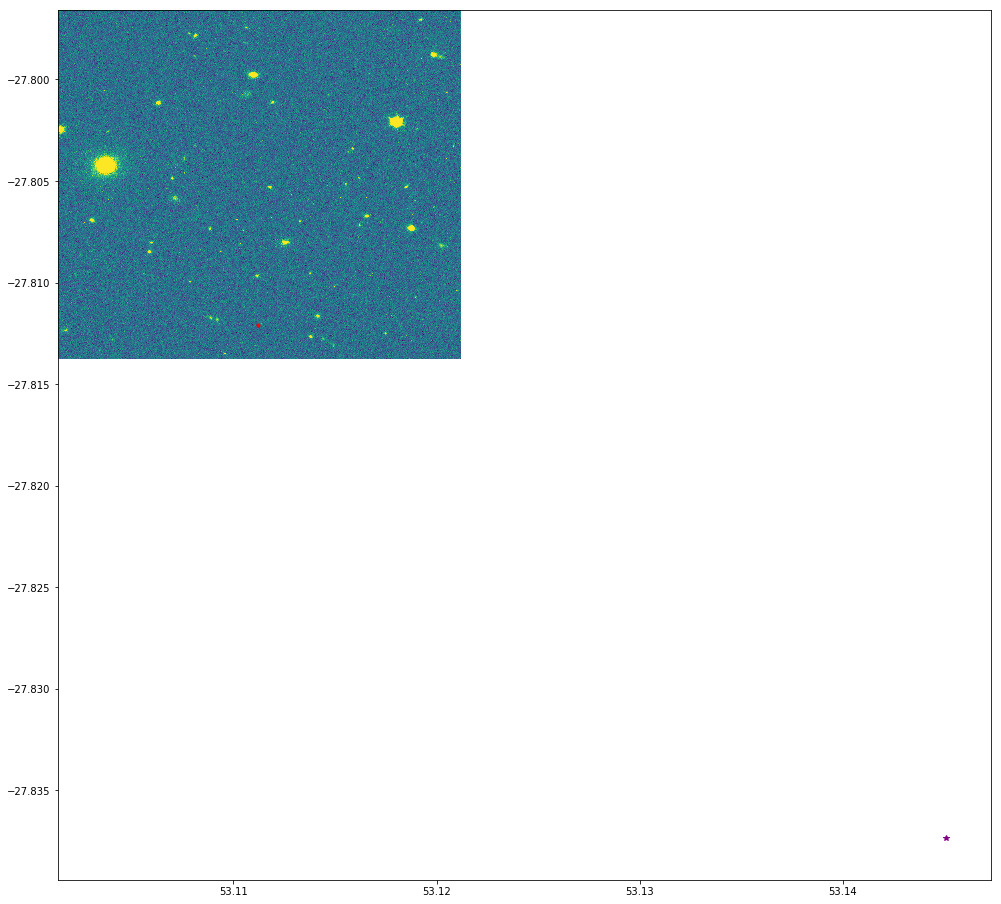

In [123]:
print(ra_cat[7478], dec_cat[7478], ra_exp1[6], dec_exp1[6])
fig=plt.figure(figsize=(18, 16))
plt.imshow(tbdat_exp1, vmin=0.093537331, vmax=0.21167476, interpolation='none', origin='lower', extent = [world_min_exp1[0], world_max_exp1[0], world_min_exp1[1], world_max_exp1[1]])
plt.plot(ra_exp1[6], dec_exp1[6], '.', color = 'red')
plt.plot(ra_cat[7478], dec_cat[7478], '*', color ='purple')   

# List Brightest 50 Sources From Exposure 2

In [88]:
#prints souces in magnitude decreasing order with corresponding ra/dec (highest 50 flux)
index = sort_reverse_index(mag_exp2)
print"number", "\t", "\t", "ABMag", "\t", "RA", "\t", "\t", "DEC"
for j in range(50):
    k = index[j]
    print k, "\t", mag_exp2[k], ra_exp2[k], "\t", dec_exp2[k]

number 		ABMag 	RA 		DEC
35 	27.4209769251 53.1138470595 	-27.8061747822
6 	26.6083493633 53.1112256257 	-27.812075246
29 	26.5849842673 53.102734282 	-27.8069653949
57 	26.314534676 53.1017231859 	-27.799455389
21 	26.1555712387 53.1102721815 	-27.8081038985
16 	26.1264136285 53.1115778262 	-27.8095865415
37 	26.0394541984 53.1164438762 	-27.8058910567
54 	25.8926259645 53.1038041438 	-27.8003734311
44 	25.8583921075 53.1076286416 	-27.804542939
45 	25.8410469161 53.1188543611 	-27.8042871414
13 	25.7627991638 53.1148145683 	-27.8102809353
10 	25.7031889654 53.1041526771 	-27.8114951721
55 	25.6565447422 53.1166758293 	-27.7996775167
58 	25.5827913229 53.1192075656 	-27.7989889291
26 	25.5359435957 53.118129367 	-27.8074331924
34 	25.4863705171 53.1197109222 	-27.8064082281
18 	25.4176681357 53.1093247489 	-27.8084770969
38 	25.2356954433 53.1151784442 	-27.8058601488
24 	25.1577284187 53.1104488989 	-27.8074365689
53 	25.1211748808 53.12042306 	-27.8006951896
11 	25.0884314912 53.118

# List Brightest 50 Sources From Exposure 3

In [89]:
#prints souces in magnitude decreasing order with corresponding ra/dec (highest 50 flux)
index = sort_reverse_index(mag_exp3)
print"number", "\t", "\t", "ABMag", "\t", "RA", "\t", "\t", "DEC"
for j in range(50):
    k = index[j]
    print k, "\t", mag_exp3[k], ra_exp3[k], "\t", dec_exp3[k]

number 		ABMag 	RA 		DEC
34 	27.5646612025 53.1138499084 	-27.8061762353
13 	26.4820104111 53.1036422296 	-27.80992876
6 	26.4693800379 53.1112296928 	-27.812076033
55 	26.3891152482 53.1017234326 	-27.7994524073
16 	26.1978836977 53.1115801574 	-27.8095867891
36 	26.1015817592 53.1164459028 	-27.8058910373
21 	26.0033172328 53.1102742302 	-27.8081020661
53 	25.9173124179 53.1166777281 	-27.7996774228
52 	25.8845941821 53.1038040431 	-27.8003728552
12 	25.8408045661 53.1148166227 	-27.8102818017
43 	25.7986860695 53.1076375084 	-27.8045437316
33 	25.6270654658 53.1197092739 	-27.806405018
56 	25.625580194 53.1192106023 	-27.7989870398
26 	25.596114052 53.1181323953 	-27.8074336074
9 	25.4926903666 53.1041548662 	-27.8114909393
18 	25.3731114609 53.1093273041 	-27.8084762652
37 	25.2568783171 53.1151802367 	-27.8058586159
24 	25.2026441741 53.1104529477 	-27.8074368163
10 	25.1364399499 53.1187424332 	-27.8108802949
11 	25.1300419785 53.1207421524 	-27.8105776831
51 	25.0775690481 53.12

# List Brightest 50 Sources From Exposure 4

In [90]:
#prints souces in magnitude decreasing order with corresponding ra/dec (highest 50 flux)
index = sort_reverse_index(mag_exp4)
print"number", "\t", "\t", "ABMag", "\t", "RA", "\t", "\t", "DEC"
for j in range(50):
    k = index[j]
    print k, "\t", mag_exp4[k], ra_exp4[k], "\t", dec_exp4[k]

number 		ABMag 	RA 		DEC
36 	26.685181311 53.1138478538 	-27.8061754823
6 	26.536144671 53.1112321168 	-27.8120762184
30 	26.5288031859 53.102736313 	-27.8069658868
58 	26.2623398755 53.1017232981 	-27.7994545004
7 	26.174733694 53.119037543 	-27.8119885815
38 	26.152030045 53.1164461095 	-27.8058925128
22 	26.0905260769 53.1102756935 	-27.8081047997
17 	26.0692524734 53.1115784223 	-27.8095879208
45 	26.057239026 53.1188528977 	-27.8042865473
56 	26.0021708071 53.1166745914 	-27.7996819105
14 	25.9197065341 53.1148139421 	-27.8102835931
55 	25.917361952 53.1038032756 	-27.80037492
11 	25.6669272878 53.1041546208 	-27.8114932944
35 	25.6535943695 53.1197128938 	-27.8064093423
59 	25.6238291907 53.1192104459 	-27.7989906845
49 	25.6175741256 53.1081771996 	-27.8031679313
27 	25.5505176393 53.1181374758 	-27.8074374687
9 	25.3557688141 53.1087623439 	-27.8117651406
19 	25.2874528209 53.1093259801 	-27.8084772461
39 	25.2796879349 53.1151808359 	-27.8058621138
54 	25.1710785768 53.1204221